In [ ]:
# Import necessary libraries
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf


87910968/87910968 [==============================] - 1s 0us/step


Found 15060 images belonging to 15 classes.
Found 3040 images belonging to 15 classes.
Epoch 1/15
471/471 [==============================] - 4852s 10s/step - loss: 0.1950 - accuracy: 0.9612 - val_loss: 0.1364 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 2/15
471/471 [==============================] - 384s 814ms/step - loss: 0.1147 - accuracy: 0.9837 - val_loss: 0.0495 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 3/15
471/471 [==============================] - 385s 816ms/step - loss: 0.0938 - accuracy: 0.9873 - val_loss: 0.1187 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 4/15
471/471 [==============================] - 387s 821ms/step - loss: 0.1019 - accuracy: 0.9880 - val_loss: 0.0345 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 5/15
471/471 [==============================] - 388s 823ms/step - loss: 0.1012 - accuracy: 0.9894 - val_loss: 0.0324 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 6/15
471/471 [==============================] - 388s 824ms/step - loss: 0.0907 - accuracy: 0.9920 - val_loss: 0.0

Epoch 1/15
471/471 [==============================] - 400s 830ms/step - loss: 0.3017 - accuracy: 0.9829 - val_loss: 0.0389 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 2/15
471/471 [==============================] - 393s 834ms/step - loss: 0.0983 - accuracy: 0.9918 - val_loss: 0.0264 - val_accuracy: 0.9977 - lr: 0.0010
Epoch 3/15
471/471 [==============================] - 378s 802ms/step - loss: 0.0625 - accuracy: 0.9938 - val_loss: 0.1898 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 4/15
471/471 [==============================] - 382s 812ms/step - loss: 0.0706 - accuracy: 0.9942 - val_loss: 0.0060 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 5/15
471/471 [==============================] - 388s 824ms/step - loss: 0.0909 - accuracy: 0.9930 - val_loss: 0.0329 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 6/15
471/471 [==============================] - 388s 823ms/step - loss: 0.0657 - accuracy: 0.9948 - val_loss: 0.0126 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 7/15
471/471 [==========================

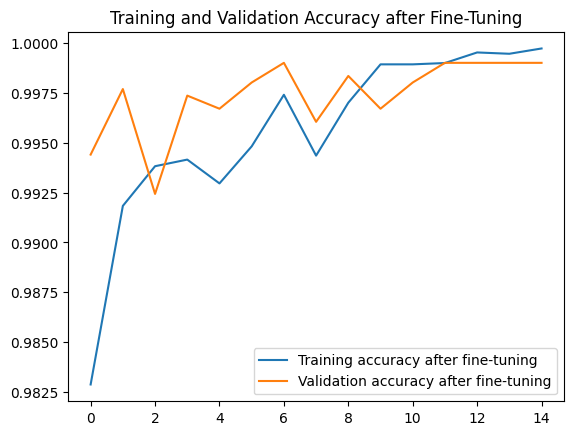

In [ ]:
# Here we load in the InceptionV3 model from Google
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add custom layers
x = base_model.output
# Initiate the model with a GlobalAveragePooling2D layer, which flattens
# information from the feature extraction layers
x = GlobalAveragePooling2D()(x)
# Stabilize the training of the neural network
x = BatchNormalization()(x)
# A fully connected hidden layer with 1024 neurons is introduced
x = Dense(1024, activation='relu')(x)
# Output layer with 15 neurons (1 for each class)
predictions = Dense(15, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers of the Transfer Learning model
for layer in base_model.layers:
    layer.trainable = False

# Use the Adam optimizer with a learning rate of 0.001
# Loss is based on categorical cross entropy and measures the accuracy
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Increase the diversity of the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Here we create data generators for training and validation datasets
# using TensorFlow's Keras API
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Project_1/Vegetables/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Project_1/Vegetables/validation',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

# ReduceLROnPlateau callback is utilized to monitor the validation loss
# Learning rate will multiplied by a factor of 0.2 when there is no improvement of validation loss
# If there is no improvement in the model’s validation loss after 5 epochs, the learning rate is reduced
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Initial training with 15 epochs
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[reduce_lr])

# Unfreeze the last 20 layers of the pre-trained model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model for fine-tuning
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with adjusted epochs
fine_tune_history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[reduce_lr])

# Visualize training and validation accuracy after fine-tuning
plt.plot(fine_tune_history.history['accuracy'], label='Training accuracy after fine-tuning')
plt.plot(fine_tune_history.history['validation_accuracy'], label='Validation accuracy after fine-tuning')
plt.title('Training and Validation Accuracy after Fine-Tuning')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

# Create Test Generator
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Project_1/Vegetables/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 3000 images belonging to 15 classes.
94/94 [==============================] - 725s 8s/step - loss: 0.0297 - accuracy: 0.9987
Test Loss: 0.02968965470790863
Test Accuracy: 0.9986666440963745
